In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchode as tode

import matplotlib.colors as colors
from scipy.optimize import fsolve
from IPython.display import clear_output

In [36]:
def sample(type='square', rng=5, db=[-5,5,-5,5], D0 = 20, dth=0, dph=0):

    yy = []
    zz = []

    if type == 'line':

        xx = D0*torch.ones([rng, 1])
        yy = torch.linspace(db[0], db[1], rng).view(-1, 1)
        zz = db[2]*torch.ones([rng, 1])

    if type == 'square':

        xx = D0*torch.ones([rng, rng])
        smpl_y = torch.linspace(db[0], db[1], rng)
        smpl_z = torch.linspace(db[2], db[3], rng)
        yy, zz = torch.meshgrid(smpl_y, smpl_z)

    if type == 'circle':

        ph = [torch.linspace(0, 2*np.pi, 4*(n+1)) for n in range(rng-1)]
        ph = torch.cat(ph)
        r = [torch.ones(4*(k+1))*(k+1)/rng for k in range(rng-1)]
        r = torch.cat(r)*abs(db[0])

        xx = D0*torch.ones_like(r)
        yy = r*torch.sin(ph)
        zz = r*torch.cos(ph)

    vx = - torch.ones_like(xx.view(-1,1))
    vy = torch.zeros_like(vx)
    vz = torch.zeros_like(vx)

    if dth != 0:
        x_ = xx*np.cos(dth) - zz*np.sin(dth)
        zz = xx*np.sin(dth) + zz*np.cos(dth)
        xx = x_

        vz = vx*np.sin(dth)
        vx = vx*np.cos(dth)

    if dph != 0:
        x_ = xx*np.cos(dph) - yy*np.sin(dph)
        yy = xx*np.sin(dph) + yy*np.cos(dph)
        xx = x_

        vy = vx*np.sin(dph)
        vx = vx*np.cos(dph)

    print(xx.shape)
    print(yy.shape)
    print(zz.shape)

    return xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1), vx, vy, vz

In [37]:
def cart2sph(XP):
    X, Y, Z, vX, vY, vZ = XP[0], XP[1], XP[2], XP[3], XP[4], XP[5]
    X2Y2 = X**2 + Y**2
    R = torch.sqrt(X2Y2 + Z**2)
    TH = torch.arccos(Z/R)
    PH = torch.arctan2(Y, X)

    print(vX.shape, R.shape)

    vR = torch.sin(TH)*(torch.cos(PH)*vX + torch.sin(PH)*vY) + torch.cos(TH)*vZ
    vTH = (torch.cos(TH)*(torch.cos(PH)*vX+torch.sin(PH)*vY) - torch.sin(TH)*vZ)/R
    vPH = (-torch.sin(PH)*vX+torch.cos(PH)*vY)/R*torch.sin(TH)


    return R, TH, PH, vR, vTH, vPH


def sph2cart(XP):
    R, TH, PH, vR, vTH, vPH= XP[0], XP[1], XP[2], XP[3], XP[4], XP[5]
    X = R*torch.sin(TH)*torch.cos(PH)
    Y = R*torch.sin(TH)*torch.sin(PH)
    Z = R*torch.cos(TH)

    vX = (vR*torch.sin(TH) + R*torch.cos(TH)*vTH)*torch.cos(PH) \
        - R*torch.sin(PH)*torch.sin(TH)*vPH
    vY = (vR*torch.sin(TH) + R*torch.cos(TH)*vTH)*torch.sin(PH) \
        + R*torch.cos(PH)*torch.sin(TH)*vPH
    vZ = vR*torch.cos(TH)-R*torch.sin(TH)*vTH

    return X, Y, Z, vX, vY, vZ


In [6]:
def GMA_spq(X, f, df):
    # X: [t, r, th, phi]
    r = X[:, 1]
    th = X[:, 2]
    phi = X[:, 3]

    outp = torch.zeros([X.shape[0], 4, 4, 4])

    f_ = f(r)
    df_ = df(r)

    # t
    outp[:, 0, 1, 0] = df_/2/f_
    outp[:, 0, 0, 1] = outp[:, 0, 1, 0]

    # r
    outp[:, 1, 0, 0] = f_*df_/2
    outp[:, 1, 1, 1] = -outp[:, 0, 1, 0]
    outp[:, 1, 2, 2] = -f_*r
    outp[:, 1, 3, 3] = outp[:, 1, 2, 2]*torch.sin(th)**2

    # th
    outp[:, 2, 1, 2] = 1/r
    outp[:, 2, 2, 1] = outp[:, 2, 1, 2]
    outp[:, 2, 3, 3] = -0.5*torch.sin(2*th)

    #phi
    outp[:, 3, 3, 1] = 1/r
    outp[:, 3, 1, 3] = outp[:, 3, 3, 1]
    outp[:, 3, 3, 2] = 1/torch.tan(th)
    outp[:, 3, 2, 3] = outp[:, 3, 3, 2]

    return outp


def EQ_func(t, X, f, df, r_H, r_lim):
    X_ = X[:, 0:4]
    Y_ = X[:, 4:]

    G = GMA_spq(X_, f, df)

    res = torch.zeros_like(X)

    for i in range(X.shape[0]):
        if (X[i,1]>r_H) & (X[i, 1] < r_lim):
            dY = - G[i] @ Y_[i] @ Y_[i]
            res[i] = torch.cat([Y_[i], dY])

    return res

In [7]:
def imcomp(EQ_, Y0, t_eval, dev='cpu'):

    N_tr = Y0.shape[0]

    t_eval = torch.kron(t_eval, torch.ones(N_tr).view(N_tr, 1))
    print(t_eval.shape)

    term = tode.ODETerm(EQ_)
    step_method = tode.Dopri5(term=term)

    Y0.to(dev)
    t_eval.to(dev)

    step_size_controller = tode.IntegralController(atol=1e-6, rtol=1e-3, term=term)

    solver = tode.AutoDiffAdjoint(step_method, step_size_controller)
    jit_solver = torch.compile(solver)

    sol = jit_solver.solve(tode.InitialValueProblem(y0=Y0, t_eval=t_eval))

    return sol

In [8]:
def thin_disk(R, X, Y, Z, norm_v, I_r, r_H):
    N_tr, t_ = R.shape[0], R.shape[1]
    F = torch.zeros(N_tr)

    emit = [[] for n in range(N_tr)]
    proj = (X*norm_v[0]+Y*norm_v[1]+Z*norm_v[2])

    for n in range(N_tr):
        for t in range(t_-1):
            if (R[n, t]>r_H):
                if (proj[n, t] > 0):
                    if (proj[n, t+1] < 0):
                        emit[n].append(t)
                        F[n] += I_r(R[n, t])
                elif (proj[n, t+1] > 0):
                    emit[n].append(t)
                    F[n] += I_r(R[n, t])

    return F, emit

In [9]:
phi_ref1 = np.pi*1.5
phi_ref2 = np.pi*2.5

def coloring(phi):
    color = []

    for i in range(len(phi)):
        if phi[i] < phi_ref1:
            color.append('k')
        elif phi[i] < phi_ref2:
            color.append('y')
        else:
            color.append('r')

    return color

def I2_r(r, f, r_p=3):
    I = torch.heaviside(r-r_p, torch.ones_like(r))*f(r)**2*torch.pow(r-r_p+1, -3)
    return I

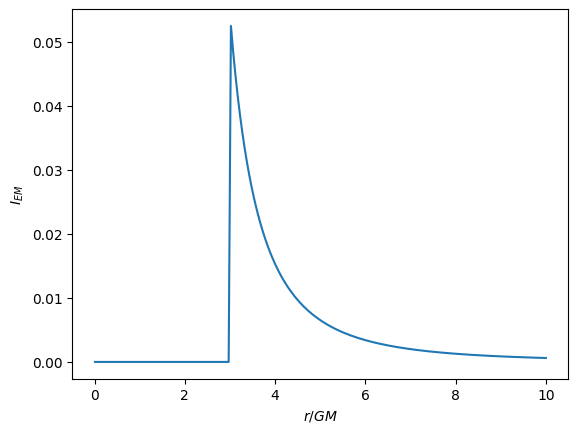

In [10]:
f = lambda r: 1 - 2/r
df = lambda r: 2/(r**2)

rprob = torch.linspace(0.01, 10, 200)
Iprob = I2_r(rprob, f)
I_nrm = sum(Iprob)
plt.plot(rprob, Iprob/I_nrm)
plt.xlabel('$r/GM$')
plt.ylabel('$I_{EM}$')
plt.show()

torch.Size([4900])
torch.Size([4900])
torch.Size([4900])
torch.Size([4900, 1]) torch.Size([4900, 1])


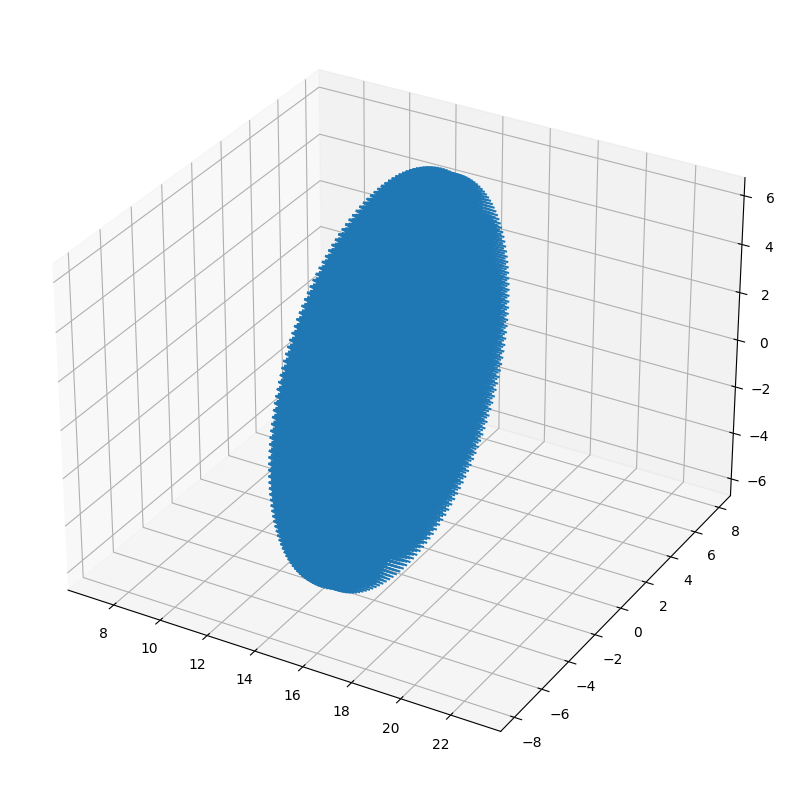

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

xx, yy, zz, vx, vy, vz = sample('circle', db=[8, 10, 0, 20], rng = 50, D0 = 15, dth=0)

r, th, ph, vr, vth, vph = cart2sph([xx, yy, zz, vx, vy, vz])

ax.quiver(xx, yy, zz, vx, vy, vz, length=1, normalize=True)

plt.axis('equal')
plt.show()

# Шварцшильд - Объёмная картина и тень

In [10]:
# Шварцшильд
t0 = torch.zeros_like(xx)
vt = torch.ones_like(xx)

Y0 = torch.cat([t0, r, th, ph, vt, vr, vth, vph], axis=1)
EQ_ = lambda t, X: EQ_func(t, X, f, df, 2, 20)

t_eval = torch.linspace(0, 80, 200).reshape(1, -1)

Res1 = imcomp(EQ_, Y0, t_eval, 'cuda')

torch.Size([4900, 200])


In [49]:
#xx, yy, zz, vx, vy, vz = Res1.ys.view(-1, 8)
#Шварцшильд
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

Y = Res1.ys
x_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.cos(Y[:, :, 3]).numpy()
y_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.sin(Y[:, :, 3]).numpy()
z_ = Y[:, :, 1]*torch.cos(Y[:, :, 2]).numpy()


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
r_h = 2
x = r_h * np.outer(np.cos(u), np.sin(v))
y = r_h * np.outer(np.sin(u), np.sin(v))
z = r_h * np.outer(np.ones(np.size(u)), np.cos(v))

r_p = 3
r_disk = torch.linspace(r_p, 10, 4)
ph_disk = torch.linspace(0, 2*np.pi, 60)
r_disk, ph_disk = torch.meshgrid(r_disk, ph_disk)
x_disk = r_disk*torch.cos(ph_disk)
y_disk = r_disk*torch.sin(ph_disk)
z_disk = torch.zeros_like(r_disk)

ax.plot_surface(x_disk, y_disk, z_disk, color='r', alpha=0.2)
ax.plot_surface(x, y, z, color='k')

dirx, diry, dirz, dirvx, dirvy, dirvz = sph2cart(torch.Tensor([15, 0, 0, -1, 0, 0]))
#ax.quiver(dirx, diry, dirz, dirvx, dirvy, dirvz, length=8, normalize=True)
#for i in range(Y.shape[0]):
    #ax.plot(x_[i], y_[i], z_[i], alpha = 0.3)

plt.plot(xI[229], yI[229], zI[229])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

plt.show()

NameError: ignored

In [12]:
#Шварцшильд
#Вычисляем тени
Y = Res1.ys
x_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.cos(Y[:, :, 3]).numpy()
y_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.sin(Y[:, :, 3]).numpy()
z_ = Y[:, :, 1]*torch.cos(Y[:, :, 2]).numpy()

norm_v1 = sph2cart(torch.Tensor([1, np.pi/2, 0, 0, 0, 0]))
norm_v2 = sph2cart(torch.Tensor([1, np.pi/4, 0, 0, 0, 0]))


I2_ = lambda r: I2_r(r,f, r_p)
tstI1, emitI1 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v1[:3], I2_, r_h)
tstI2, emitI2 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v2[:3], I2_, r_h)

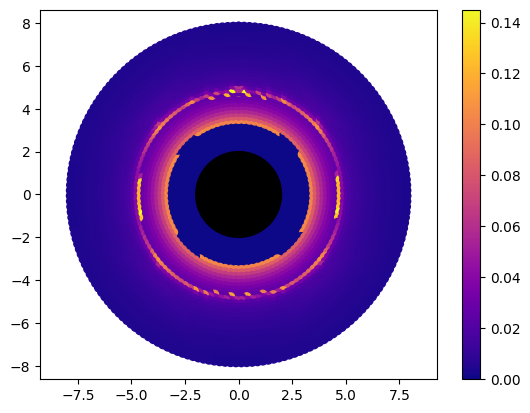

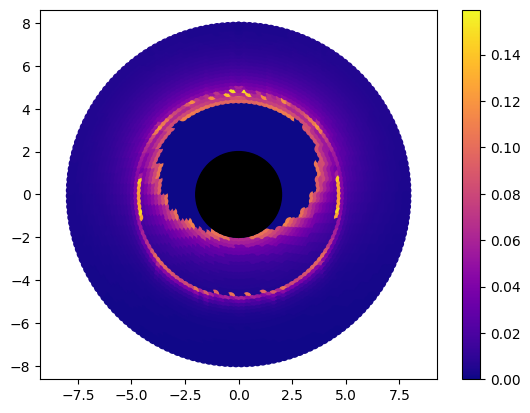

In [13]:
#Шварцшильд
#Рисуем тени
circle1 = plt.Circle((0, 0), 2, color='k')
circle2 = plt.Circle((0, 0), 2, color='k')
cmap = plt.cm.plasma

fig = plt.figure()
ax = fig.add_subplot()
cm = ax.scatter(yy, zz, c=tstI1.view(-1, 1), cmap=cmap)
ax.add_patch(circle1)
plt.colorbar(cm)
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
cm = ax.scatter(yy, zz, c=tstI2.view(-1, 1), cmap=cmap)
ax.add_patch(circle2)
plt.colorbar(cm)
plt.axis('equal')
plt.show()

In [18]:
D0 = 15

rI, thI, phI, vrI, vthI, vphI = cart2sph(sample('line', db=[0, 10, 0, 20], rng = 501, D0 = 10, dth=0))
t0I = torch.zeros_like(rI)
vtI = torch.ones_like(rI)

Y0 = torch.cat([t0I, rI, thI, phI, vtI, vrI, vthI, vphI], axis=1)

t_eval = torch.linspace(0, 80, 100).reshape(1, -1)
EQ_ = lambda t, X: EQ_func(t, X, f, df, 2, 20)

Res2 = imcomp(EQ_, Y0, t_eval, 'cuda')

torch.Size([501, 1])
torch.Size([501, 1])
torch.Size([501, 1])
torch.Size([501, 1]) torch.Size([501, 1])
torch.Size([501, 100])


KeyboardInterrupt: ignored

(tensor(-1.), tensor(-0.), tensor(-4.3711e-08), tensor(0.), tensor(-0.), tensor(0.))


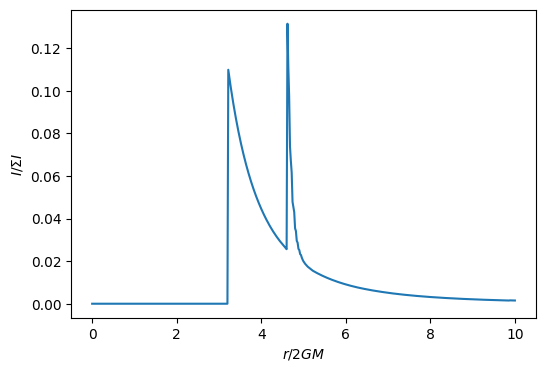

In [24]:
rI = Res2.ys[:, :, 1]
thI =Res2.ys[:, :, 2]
phI =Res2.ys[:, :, 3]

xI = rI*torch.cos(phI)*torch.sin(thI)
yI = rI*torch.sin(phI)*torch.sin(thI)
zI = rI*torch.cos(thI)

fig2, ax2 = plt.subplots(figsize=(6, 4))
norm_v = sph2cart(torch.Tensor([1, -np.pi/2, 0, 0, 0, 0]))
print(norm_v)
I2_s = lambda r: I2_r(r, f)
tstI, emit = thin_disk(rI, xI, yI, zI, norm_v, I2_s, 2)

ax2.plot(yI[:, 0], tstI)
plt.ylabel('$I/\Sigma I$')
plt.xlabel('$r/2GM$')
plt.show()

# Райснер-Нордстрём - Тень

In [11]:
C=0.2

fRN = lambda r: 1 - 2/r + C/(r**2)
dfRN = lambda r: 2/(r**2) - 2*C/(r**3)

eq_r_p = lambda r: r*dfRN(r)-2*fRN(r)
r_H_RN = float(fsolve(fRN, 2))
r_p_RN = float(fsolve(eq_r_p, 3))
b_cr_RN = float(r_p_RN/np.sqrt(fRN(r_p_RN)))

print('r_H = ', r_H_RN)
print('r_p = ', r_p_RN)
print('b_cr = ', b_cr_RN)

r_H =  1.8944271909999162
r_p =  2.8601470508735445
b_cr =  5.0156116496974015


In [15]:
t0 = torch.zeros_like(xx)
vt = torch.ones_like(xx)

Y0 = torch.cat([t0, r, th, ph, vt, vr, vth, vph], axis=1)
EQ_ = lambda t, X: EQ_func(t, X, fRN, dfRN, r_H_RN, 20)
z
t_eval = torch.linspace(0, 80, 200).reshape(1, -1)

ResRN1 = imcomp(EQ_, Y0, t_eval, 'cuda')

torch.Size([4900, 200])


In [16]:
#Вычисляем тени
Y = ResRN1.ys
x_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.cos(Y[:, :, 3]).numpy()
y_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.sin(Y[:, :, 3]).numpy()
z_ = Y[:, :, 1]*torch.cos(Y[:, :, 2]).numpy()

norm_v1 = sph2cart(torch.Tensor([1, np.pi/2, 0, 0, 0, 0]))
norm_v2 = sph2cart(torch.Tensor([1, np.pi/4, 0, 0, 0, 0]))

I2_RN = lambda r: I2_r(r,fRN,  r_p_RN)
tstI1, emitI1 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v1[:3], I2_RN, r_H_RN)
tstI2, emitI2 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v2[:3], I2_RN, r_H_RN)

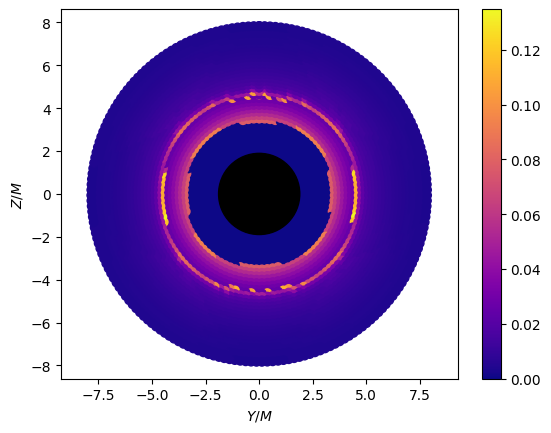

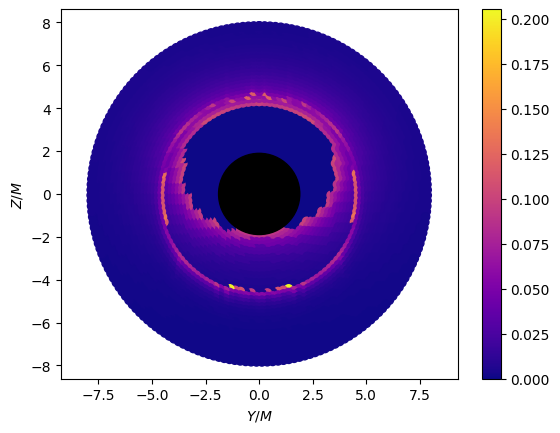

In [17]:
circle1 = plt.Circle((0, 0), r_H_RN, color='k')
circle2 = plt.Circle((0, 0), r_H_RN, color='k')
cmap = plt.cm.plasma

fig = plt.figure()
ax = fig.add_subplot()
cm = ax.scatter(yy, zz, c=tstI1.view(-1, 1), cmap=cmap)
plt.colorbar(cm)
ax.add_patch(circle1)
plt.xlabel('$Y/M$')
plt.ylabel('$Z/M$')
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
cm = ax.scatter(yy, zz, c=tstI2.view(-1, 1), cmap=cmap)
ax.add_patch(circle2)
plt.colorbar(cm)
plt.xlabel('$Y/M$')
plt.ylabel('$Z/M$')
plt.axis('equal')
plt.show()

In [ ]:
D0 = 15

rI, thI, phI, vrI, vthI, vphI = cart2sph(sample('line', db=[0, 10, 0, 20], rng = 501, D0 = 10, dth=0))
t0I = torch.zeros_like(rI)
vtI = torch.ones_like(rI)

Y0 = torch.cat([t0I, rI, thI, phI, vtI, vrI, vthI, vphI], axis=1)

t_eval = torch.linspace(0, 80, 100).reshape(1, -1)
EQ_ = lambda t, X: EQ_func(t, X, fRN, dfRN, r_H_RN, 20)

Res2 = imcomp(EQ_, Y0, t_eval, 'cuda')



(tensor(-1.), tensor(-0.), tensor(-4.3711e-08), tensor(0.), tensor(-0.), tensor(0.))


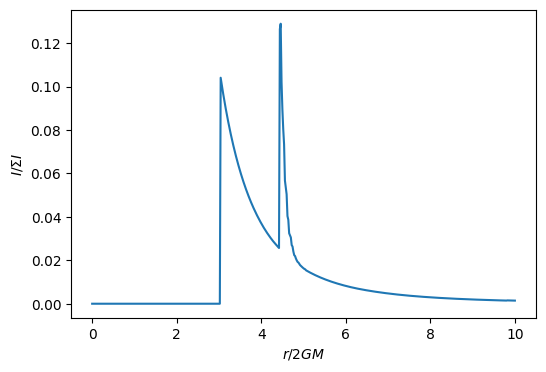

In [19]:
rI = Res2.ys[:, :, 1]
thI =Res2.ys[:, :, 2]
phI =Res2.ys[:, :, 3]

xI = rI*torch.cos(phI)*torch.sin(thI)
yI = rI*torch.sin(phI)*torch.sin(thI)
zI = rI*torch.cos(thI)

fig2, ax2 = plt.subplots(figsize=(6, 4))
norm_v = sph2cart(torch.Tensor([1, -np.pi/2, 0, 0, 0, 0]))
print(norm_v)
I2_s = lambda r: I2_r(r, fRN, r_p_RN)
tstI, emit = thin_disk(rI, xI, yI, zI, norm_v, I2_s, r_H_RN)

ax2.plot(yI[:, 0], tstI)
plt.ylabel('$I/\Sigma I$')
plt.xlabel('$r/2GM$')
plt.show()

# Эйлер-Гейзенберг: Тень

In [25]:
C = 0.2
h = 2000000

B_EH = float(1/225/np.pi/np.sqrt(137)*C**2*h)
print(B_EH)

fEH = lambda r: 1 - 2/r + C/(r**2) - B_EH/(r**6)
dfEH = lambda r: 2/(r**2) - 2*C/(r**3) + 7*B_EH/(r**7)

eq_r_p = lambda r: r*dfEH(r)-2*fEH(r)
r_H_EH = float(fsolve(fEH, 2))
r_p_EH = float(fsolve(eq_r_p, 3))
b_cr_EH = float(r_p_EH/np.sqrt(fEH(r_p_EH)))

print('r_H = ', r_H_EH)
print('r_p = ', r_p_EH)
print('b_cr = ', b_cr_EH)

9.669350712464789
r_H =  2.1277287433195067
r_p =  3.0367634083659265
b_cr =  5.127485496574401


In [27]:
t0 = torch.zeros_like(xx)
vt = torch.ones_like(xx)

Y0 = torch.cat([t0, r, th, ph, vt, vr, vth, vph], axis=1)
EQ_ = lambda t, X: EQ_func(t, X, fEH, dfEH, r_H_EH, 20)

t_eval = torch.linspace(0, 80, 150).reshape(1, -1)

ResEH1 = imcomp(EQ_, Y0, t_eval, 'cuda')

torch.Size([4900, 150])


In [28]:
Y = ResEH1.ys
x_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.cos(Y[:, :, 3]).numpy()
y_ = Y[:, :, 1]*torch.sin(Y[:, :, 2])*torch.sin(Y[:, :, 3]).numpy()
z_ = Y[:, :, 1]*torch.cos(Y[:, :, 2]).numpy()

norm_v1 = sph2cart(torch.Tensor([1, np.pi/2, 0, 0, 0, 0]))
norm_v2 = sph2cart(torch.Tensor([1, np.pi/4, 0, 0, 0, 0]))
I2_EH = lambda r: I2_r(r, fEH, r_p_EH)
tstI1, emitI1 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v1[:3], I2_EH, r_H_EH)
tstI2, emitI2 = thin_disk(Y[:, :, 1], x_, y_, z_, norm_v2[:3], I2_EH, r_H_EH)

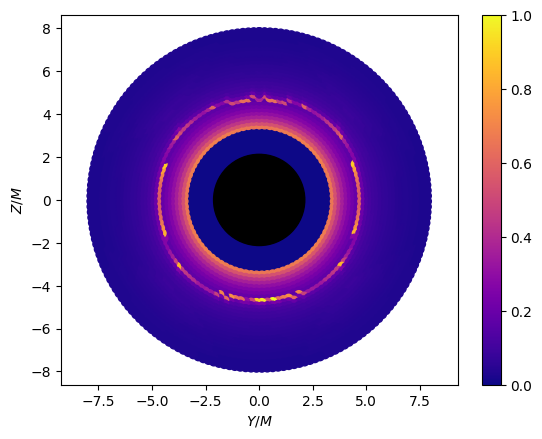

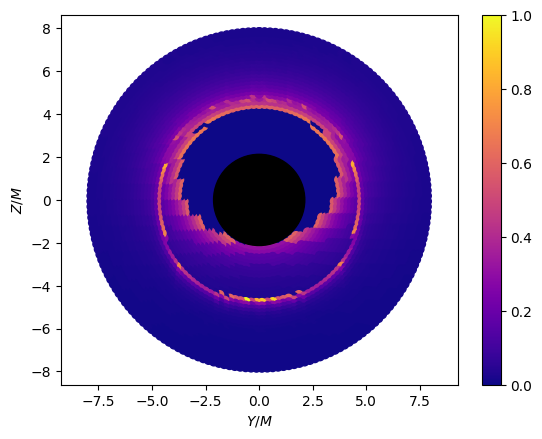

In [32]:
circle1 = plt.Circle((0, 0), r_H_EH, color='k')
circle2 = plt.Circle((0, 0), r_H_EH, color='k')
cmap = plt.cm.plasma

fig = plt.figure()
ax = fig.add_subplot()

cm = ax.scatter(yy, zz, c=tstI1.view(-1, 1)/max(tstI1), cmap=cmap)
ax.add_patch(circle1)
plt.colorbar(cm, ax=ax)
plt.xlabel('$Y/M$')
plt.ylabel('$Z/M$')
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
cm = ax.scatter(yy, zz, c=tstI2.view(-1, 1)/max(tstI2), cmap=cmap)
plt.colorbar(cm, ax=ax)
ax.add_patch(circle2)
plt.xlabel('$Y/M$')
plt.ylabel('$Z/M$')
plt.axis('equal')
plt.show()

In [42]:
C = 0.2
h = 2000000

B_EH = float(1/225/np.pi/np.sqrt(137)*C**2*h)
print(B_EH)

fEH = lambda r: 1 - 2/r + C/(r**2) - B_EH/(r**6)
dfEH = lambda r: 2/(r**2) - 2*C/(r**3) + 7*B_EH/(r**7)

eq_r_p = lambda r: r*dfEH(r)-2*fEH(r)
r_H_EH = float(fsolve(fEH, 2))
r_p_EH = float(fsolve(eq_r_p, 3))
b_cr_EH = float(r_p_EH/np.sqrt(fEH(r_p_EH)))

print('r_H = ', r_H_EH)
print('r_p = ', r_p_EH)
print('b_cr = ', b_cr_EH)

rI, thI, phI, vrI, vthI, vphI = cart2sph(sample('line', db=[0, 10, 0, 20], rng = 501, D0 = 10, dth=0))
t0I = torch.zeros_like(rI)
vtI = torch.ones_like(rI)

Y0 = torch.cat([t0I, rI, thI, phI, vtI, vrI, vthI, vphI], axis=1)

t_eval = torch.linspace(0, 80, 100).reshape(1, -1)
EQ_ = lambda t, X: EQ_func(t, X, fEH, dfEH, r_H_EH, 20)

Res2 = imcomp(EQ_, Y0, t_eval, 'cuda')


9.669350712464789
r_H =  2.1277287433195067
r_p =  3.0367634083659265
b_cr =  5.127485496574401
torch.Size([501, 1])
torch.Size([501, 1])
torch.Size([501, 1])
torch.Size([501, 1]) torch.Size([501, 1])
torch.Size([501, 100])


(tensor(-1.), tensor(-0.), tensor(-4.3711e-08), tensor(0.), tensor(-0.), tensor(0.))


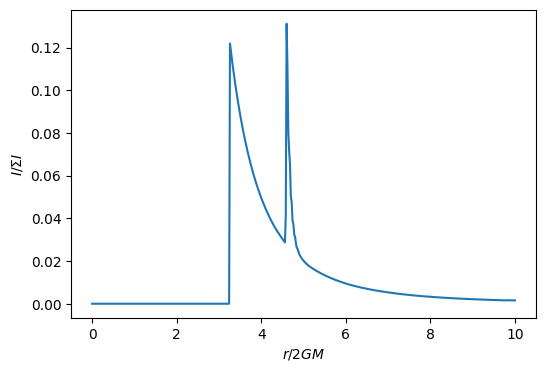

In [43]:
rI = Res2.ys[:, :, 1]
thI =Res2.ys[:, :, 2]
phI =Res2.ys[:, :, 3]

xI = rI*torch.cos(phI)*torch.sin(thI)
yI = rI*torch.sin(phI)*torch.sin(thI)
zI = rI*torch.cos(thI)


norm_v = sph2cart(torch.Tensor([1, -np.pi/2, 0, 0, 0, 0]))
print(norm_v)
I2_s = lambda r: I2_r(r, fEH, r_p_EH)
tstI, emit = thin_disk(rI, xI, yI, zI, norm_v, I2_s, r_H_EH)

fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.plot(yI[:, 0], tstI)
plt.ylabel('$I/\Sigma I$')
plt.xlabel('$r/2GM$')
plt.show()

In [48]:
for i in range(len(emit)):
  if len(emit[i])>1:
    print(i, emit[i])

149 [11, 12]
156 [11, 12]
158 [11, 12]
162 [11, 12]
167 [11, 12]
188 [11, 13]
204 [11, 15]
208 [11, 15]
227 [11, 19]
228 [11, 19]
229 [11, 20, 30]
230 [11, 20]
231 [11, 20]
232 [11, 21]
233 [11, 21]
234 [11, 21]
235 [11, 22]
236 [11, 22]
237 [11, 23]
238 [11, 23]
239 [11, 24]
240 [11, 24]
241 [11, 25]
242 [11, 26]
243 [11, 26]
244 [11, 27]
245 [11, 28]
246 [11, 29]
247 [11, 30]
248 [11, 31]
249 [11, 32]
250 [11, 34]
251 [11, 35]
252 [11, 37]
253 [11, 39]
254 [11, 42]
